# Lab 3 — dimensionality reduction
**Internet Analytics - Lab 3**

---

**Group:** *K*

**Names:**

* *Robin Lang*
* *Kim Lan Phan Hoang*

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

relevance_file_name = "relevance_array.npy"

## TESTS PLEASE DELETE

``` !hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2 ```

In [4]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
#tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

In [5]:
data.filter(lambda x: x["movieId"]==1 & x["tagId"]==1).take(1)

[{'movieId': 1, 'relevance': 0.025000000000000022, 'tagId': 1}]

In [6]:
tags.take(10)

[{'tag': '007', 'tagId': 1},
 {'tag': '007 (series)', 'tagId': 2},
 {'tag': '18th century', 'tagId': 3},
 {'tag': '1920s', 'tagId': 4},
 {'tag': '1930s', 'tagId': 5},
 {'tag': '1950s', 'tagId': 6},
 {'tag': '1960s', 'tagId': 7},
 {'tag': '1970s', 'tagId': 8},
 {'tag': '1980s', 'tagId': 9},
 {'tag': '19th century', 'tagId': 10}]

In [7]:
scoresByTag = data.groupBy(lambda x: x["tagId"])

In [8]:
scoresByTag.take(10)

[(552, <pyspark.resultiterable.ResultIterable at 0x7f72081d04e0>),
 (1068, <pyspark.resultiterable.ResultIterable at 0x7f72081d0550>),
 (456, <pyspark.resultiterable.ResultIterable at 0x7f72040b5710>),
 (792, <pyspark.resultiterable.ResultIterable at 0x7f72040b5780>),
 (570, <pyspark.resultiterable.ResultIterable at 0x7f71ffcc5d68>),
 (882, <pyspark.resultiterable.ResultIterable at 0x7f71ff992390>),
 (576, <pyspark.resultiterable.ResultIterable at 0x7f71ff65b978>),
 (816, <pyspark.resultiterable.ResultIterable at 0x7f71ff325f60>),
 (294, <pyspark.resultiterable.ResultIterable at 0x7f71feff1588>),
 (870, <pyspark.resultiterable.ResultIterable at 0x7f71fecbab70>)]

---

**construct ratings array**

In [9]:
# relaunch!! may contain error!!

In [10]:
n_movies = movies.map(lambda x: x["movieId"]).max()
n_tags = tags.map(lambda x: x["tagId"]).max()

In [11]:
print("movies:", n_movies, "| tags:", n_tags)

movies: 131262 | tags: 1128


In [12]:
relevance_array = np.zeros((n_tags, n_movies), dtype=float)

for i in data.toLocalIterator():
    relevance_array[i["tagId"]-1][i["movieId"]-1] = i["relevance"]

**save to file**

In [13]:
np.save(relevance_file_name, relevance_array)

**open existing array file**

In [14]:
relevance_array_load = np.load(relevance_file_name)

## Exercice 3.1

### Plot the variance of each dimension / tag.

In [15]:
rel_var = []
for i in relevance_array_load:
    rel_var.append(np.var(i))

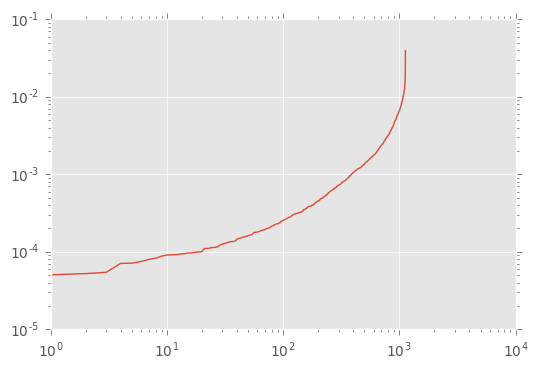

In [16]:
plt.loglog(sorted(rel_var))


### Plot the eigenvalues of the covariance matrix.

In [56]:
rel_cov = np.cov(relevance_array_load)
rel_eigvals, rel_eigvecs = la.eigh(rel_cov)

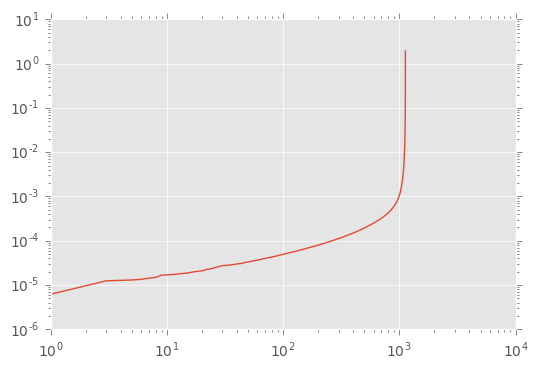

In [57]:
plt.loglog(rel_eigvals)

In [58]:
# WAAAY SLOWER, BUT SAME RESULT
rel_cov2 = 1/n_tags * relevance_array_load.T @ relevance_array_load
rel_eigvals2, rel_eigvecs2 = la.eigh(rel_cov)

MemoryError: 

In [ ]:
plt.loglog(rel_eigvals2)

### Explain the implications for dimensionality reduction.

Dimensionality reduction means you take some principal directions and project the data onto them. <br>
By doing this you effectively lose some precision, however the dimension of the data can often be greatly decreased, improving performance.

**How many principal directions do you need to capture $2 \over 3$ of the variability in the data?**

In [ ]:
sum_eig = sum(rel_eigvals)
s = 0
n_eigvals = len(rel_eigvals)
index = 0

while s < sum_eig*2/3:
    s += rel_eigvals[n_eigvals-index-1]
    index += 1

print("to capture 2/3 of the variability you need", index, "principal directions")

## Exercice 3.2

### For the five first principal directions, find the 10 tags that have the highest and lowest coordinates in that direction.

In [ ]:
# first 5 principle directions (i think anyway)
rel_dirs = []
for i in range(5):
    rel_dirs.append(rel_cov @ rel_eigvecs[-i-1])

In [ ]:
def find_tags(tags, direction):
    N = len(tags)
    
    scores = np.zeros(N)

    for i in range(N):
        scores[i] = np.dot(tags[i], direction)
    
    top10 = np.argsort(-scores)[:10]
    bottom10 = np.argsort(scores)[:10] # bottom 10 are always 0, as there are empty tags, where all entries are 0
    
    print("top10:", top10+1)
    print("bottom10:", bottom10+1)

In [ ]:
find_tags(relevance_array_load.T, rel_dirs[0])

### What concepts would you use to describe these dimensions?

WHAT??

## Exercice 3.3

### Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. Color the nodes by their Rotten Tomatoes score.

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()
import pickle

In [ ]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
for movie in movies:
#    print(movie)
    pass

In [ ]:
projected_x = [] # first principal direction
projected_y = [] # second principal direction

for i in movies:
    projected_x.append(np.dot(relevance_array_load.T[i[0]-1], rel_dirs[0]))
    projected_y.append(np.dot(relevance_array_load.T[i[0]-1], rel_dirs[1]))

In [59]:
# Continuous colors
from matplotlib.colors import rgb2hex 

# colors:   0% -> red
#          50% -> yellow
#         100% -> green
# interpolated in between
def rottenColor(val):
    if val<0.5:
        return rgb2hex([1.0, 2*val, 0.0])
    else:
        return rgb2hex([2*(1.0-val), 1.0, 0.0])

source = ColumnDataSource(
    data={
        "x": projected_x,
        "y": projected_y,
        "name": [x[1] for x in movies],
        "color": [rottenColor(x[2]) for x in movies],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=960, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=1.0)
show(p, notebook_handle=True)

***PROBLEM: PRETTY SURE THAT'S SUPPOSED TO BE CENTERED AROUND 0***

### Explain the coordinates of a few of the movies.

The first principal direction is on the X direction, the second is on Y. A result close to 0 means that movie is perfectly represented by that principal direction. For example, "King's Speech" is very close to 0 on the Y axism which means that its tags are almost perfectly represented by that direction.

### How do the PCA directions correlate with the Rotten Tomatoes score?

iunno